# Pet Dog Behavior Study - Phase I

In [1]:
import sqlite3
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations

# IPython magics for this notebook.
%matplotlib inline

# Initiate plotly IPython notebook mode.
py.init_notebook_mode(connected=True)

In [2]:
TOTAL_USERS = 0
TOTAL_DOGS = 0
prevalence_cal = lambda x: (x / 5018) * 100
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
SIG_P = 0.01
BIAS_FILTER = '''
    JOIN users
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')
CATEGORY = ['Aggression', 'Fear/anxiety', 'Compulsion', 'House soiling', 'Excessive barking', 
            'Jumping', 'Mounting/humping', 'Consuming feces', 'Destructive behavior',
            'Rolling in repulsive material', 'Running away/escaping', 
            'Overactivity/hyperactivity']
LABELS = {}
FIELDS = {}
CHI2_MATRIX = pd.DataFrame()

In [3]:
def dataFrameFromQuery(query, labels):
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def replaceFields(df, replacement_dict):
    for key, value in replacement_dict.items():
        df = df.replace(key, value)
    return df

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(prevalence_cal)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['sum', 'prevalence']
    return rv

def convertToNumeric(df):
    for col in df:
        df[col] = pd.to_numeric(df[col])
    return df

def createDataFrame(table, fields, labels, filtered):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        query += ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def createNumericDataFrame(table, fields, labels, filtered):
    df = createDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def addToLabels(letter, labels, category):
    LABELS[category] = {}
    for counter, value in enumerate(labels, 1):
        key = '{}{:02}'.format(letter, counter)
        LABELS[category][key] = value

def addToFields(fields, category):
    FIELDS[category] = fields
    
def createChiSquaredMatrix():
    fields = ''
    for cat, sublist in FIELDS.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    locs = []
    for cat, subdict in LABELS.items():
        for key, value in  subdict.items():
            locs.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, locs, filtered=True)
    cols = []
    chi2 = {}
    for col in df:
        cols.append(col)
        chi2[col] = {}
    pairs = list(combinations(df.columns,2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        chi2[pair[0]][pair[1]] = c
        chi2[pair[1]][pair[0]] = c
    df = pd.DataFrame(chi2).sort_index(ascending=True)
    return df

def checkSignificance(p, sig=SIG_P):
    if p < sig:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig)

In [4]:
# Aggression.
labels = ['Familiar people in the home', 'Stangers visiting the home',
          'Stangers away from the home', 'Another dog in the home',
          'Unfamiliar dogs visiting the home', 'Unfamiliar dogs on walks (off lead)',
          'Unfamiliar dogs on walks (on lead)', 'Veterinarians', 'Trainers', 'Groomers',
          'Animals other than dogs in the home']
addToLabels('A', labels, CATEGORY[0])
fields = ['q03_main_1', 'q03_main_2', 'q03_main_3', 'q03_main_4', 'q03_main_5', 'q03_main_6',
          'q03_main_7', 'q03_main_8', 'q03_main_9', 'q03_main_10', 'q03_main_11']
addToFields(fields, CATEGORY[0])

# Fear/anxiety.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Crowd phobia', 'Phobia of other dogs',
          'PTSD', 'Generalized anxiety', 'Situational anxiety', 'Veterinarian phobia',
          'Separation anxiety', 'Travel anxiety', 'Other']
addToLabels('B', labels, CATEGORY[1])
fields = ['q04_1', 'q04_2', 'q04_3', 'q04_4', 'q04_5', 'q04_6', 'q04_7', 'q04_8', 'q04_9',
          'q04_10', 'q04_11']
addToFields(fields, CATEGORY[1])

# Compulsion.
labels = ['Spinning', 'Tail chasing', 'Shadow/light chasing', 'Running in geometric patterns',
          'Licking of wrist/hock', 'Fly snapping', 'Sucking flank region/blankets',
          'Tennis ball fetish', 'Collecting/arranging objects', 'Nail biting',
          'Digging in yard', 'Stone/rock chewing', 'Other']
addToLabels('C', labels, CATEGORY[2])
fields = ['q05_main_1', 'q05_main_2', 'q05_main_3', 'q05_main_4', 'q05_main_5', 'q05_main_6',
          'q05_main_7', 'q05_main_8', 'q05_main_9', 'q05_main_10', 'q05_main_11',
          'q05_main_12', 'q05_main_13']
addToFields(fields, CATEGORY[2])

# House soiling.
labels = ['Urine', 'Feces', 'Urine and feces', 'Specific locations', 'Anywhere',
          'Owner present', 'Owner away', 'Excited/overwhelmed']
addToLabels('D', labels, CATEGORY[3])
fields = ['q06_situation_1', 'q06_situation_2', 'q06_situation_3', 'q06_soil_location_1',
          'q06_soil_location_2', 'q06_situation_1', 'q06_situation_2', 'q06_situation_3']
addToFields(fields, CATEGORY[3])

# Excessive barking.
labels = ['Owner present', 'Owner away', 'To get attention', 'At tiggers (inside)',
          'At triggers (outside)', 'During car rides']
addToLabels('E', labels, CATEGORY[4])
fields = ['q07_sitatuon_1', 'q07_sitatuon_2', 'q07_sitatuon_3', 'q07_sitatuon_4',
          'q07_sitatuon_5', 'q07_sitatuon_6']
addToFields(fields, CATEGORY[4])

# Jumping.
labels = ['Owner', 'Family members', 'Strangers']
addToLabels('F', labels, CATEGORY[5])
fields = ['q08_who_1', 'q08_who_2', 'q08_who_3']
addToFields(fields, CATEGORY[5])

# Mounting/humping.
labels = ['People', 'Familiar dogs', 'Unfamiliar dogs', 'Inanimate objects']
addToLabels('G', labels, CATEGORY[6])
fields = ['q09_main_1', 'q09_main_2', 'q09_main_3', 'q09_main_4']
addToFields(fields, CATEGORY[6])

# Consuming feces.
labels = ['Their own', "Other dogs'", "Other species'"]
addToLabels('H', labels, CATEGORY[7])
fields = ['q10_main_1', 'q10_main_2', 'q10_main_3']
addToFields(fields, CATEGORY[7])

# Destructive behavior.
labels = ['Owner is home', 'Owner is away']
addToLabels('I', labels, CATEGORY[8])
fields = ['q11_situation_1', 'q11_situation_2']
addToFields(fields, CATEGORY[8])

# Rolling in repulsive materials.
labels = ['Urine', 'Feces', 'Dead Stuff', 'Garbage']
addToLabels('J', labels, CATEGORY[9])
fields = ['q12_main_1', 'q12_main_2', 'q12_main_3', 'q12_main_4']
addToFields(fields, CATEGORY[9])

# Running away/escaping.
labels = ['Escapes when out', 'Escapes from home', 'Escapes from confinement',
          'Returns home after escape']
addToLabels('K', labels, CATEGORY[10])
fields = ['q14_out', 'q14_house', 'q14_conf', 'q14_return']
addToFields(fields, CATEGORY[10])

# Overactivity/hyperactivity.
labels = ['Constant moving/jumping', 'Difficulty settling', 'Highly distractible',
          'Impulsive']
addToLabels('L', labels, CATEGORY[11])
fields = ['q15_main_1', 'q15_main_2', 'q15_main_3', 'q15_main_4']
addToFields(fields, CATEGORY[11])

## Participant Demographics

### Number of Participants

In [5]:
df = dataFrameFromQuery('SELECT COUNT(*) FROM users', ['count'])
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('Total number of participants: %d' %TOTAL_USERS)

Total number of participants: 3201


### Motivation for Enrollment

In [6]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'to help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
    
# Create a bar graph to illustrate breakdown of responses.
sums = df.sum()
sums = sums.sort_values(ascending=True)
data = [go.Bar(y=sums.index.values,
               x=sums.values,
               orientation='h')]
layout = go.Layout(title="Motivation for Study Enrollment",
                   xaxis=dict(title='number of participants'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=600,
                   height=400)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# NOTE: This does not include a count of users who did not provide a reason.

## Participating Dog Demographics

### Number of Participating Dogs

In [7]:
df = dataFrameFromQuery('SELECT COUNT(*) FROM dogs', ['count'])
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('Total number of participating dogs: %d' %TOTAL_DOGS)

Total number of participating dogs: 5018


### Gender of Participating Dogs

In [8]:
# Construct the dataframe.
fields = 'dog_sex'
labels = ['Gender']
df = createDataFrame(DOG_TABLE, fields, labels, filtered=False)
replacements = {'':'No response', '1':'Male', '2':'Female'}
df = replaceFields(df, replacements)

# Calculate sums and prevalences.
calc = getValueCountAndPrevalence(df, labels[0])

# Display the results as a table.
data = [go.Table(header=dict(values=[labels[0], 'Number of Dogs', 'Prevalence (%)'],
                             fill = dict(color='#B0C4DE'),
                             align = ['left'] * 3),
                 cells=dict(values=[calc.index.values, calc['sum'].values, 
                                    calc['prevalence'].values],
                            align = ['left'] * 3,
                            format = [None, 'd', '.2f']))]
layout = go.Layout(title='Gender of Participating Dogs',
                   width=500,
                   height=200,
                   margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Neutered Status of Participating Dogs

In [9]:
# Construct the dataframe.
fields = 'dog_spayed'
labels = ['Neutered']
df = createDataFrame(DOG_TABLE, fields, labels, filtered=False)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
df = replaceFields(df, replacements)

# Calculate sums and prevalences.
calc = getValueCountAndPrevalence(df, labels[0])

data = [go.Table(header=dict(values=[labels[0], 'Number of Dogs', 'Prevalence (%)'],
                             fill = dict(color='#B0C4DE'),
                             align = ['left'] * 3),
                 cells=dict(values=[calc.index.values, calc['sum'].values, 
                                    calc['prevalence'].values],
                            align = ['left'] * 3,
                            format = [None, 'd', '.2f']))]
layout = go.Layout(title='Neutered Status of Participating Dogs',
                   width=500,
                   height=225,
                   margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Breakdown of Participating Purebred Breeds

In [10]:
# Create the necessary dataframe.
fields = 'purebred_breed'
labels = ['breed']
df = createDataFrame(DOG_TABLE, fields, labels, filtered=False)

df = df.replace('', np.nan, regex=True)
df = df.replace('118', 'Labrador retriever', regex=True)
df = df.replace('92', 'German shepherd', regex=True)
df = df.replace('97', 'Golden retriever', regex=True)
df = df.replace('151', 'Poodle', regex=True)
df = df.replace('43', 'Border collie', regex=True)
df = df.replace('71', 'Cocker spaniel', regex=True)
df = df.replace('16', 'Australian shepherd', regex=True)
df = df.replace('75', 'Dachshund', regex=True)
df = df.replace('64', 'Chihuahua', regex=True)
df = df.replace('170', 'Shetland sheepdog', regex=True)

sums = df['breed'].value_counts()
sums = sums[:10]
prevalence_cal = lambda x: (x / 5018) * 100
prevalences = sums.apply(prevalence_cal)

trace = go.Table(
    columnwidth = [100, 100, 100],
    header=dict(values=['Breed', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(
    title='Top 10 Participating Breeds',
    width=700, height=350, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

## Prevalence of Overall Behavior Problems

Prevalence is defined as the proportion of a population found to be affected by a medical condition. This section aims to calculate the aggregate prevalence of the most common behavior problems in a given canine population. It is in this section that we define and apply a filter to remove bias from the data set.

### Bias Filter:

The current bias filter focuses largely on the participants' motivation for enrollment ("Why did you decide to participate in this survey?", pg. 1). The answer choice "my dog may have a behavior problem" was included to identify participants who enrolled with motivational bias. However, participants may not have a motiivational bias towards all of their participating dogs. To account for this, the question "do you believe \[dog\] has ever had a behavior problem" (pg. 4) was used in conjunction with the enrollment motivation to identify the dogs most likely to be influenced by the bias of the participating owner. 

### Gross and Adjusted Sums:

In [11]:
# Create the necessary dataframe.
query = '''
    SELECT record_id, question_reason_for_part_3, q02_score
    FROM users
    JOIN dogs
    USING(record_id)'''
df_gross = pd.read_sql_query(query, CON)
df_gross.columns = ['id', 'suspicion', 'problems']

# Get a count of the dogs with reported behavior problem.
# If the "problems" column does not equal zero, then a behavior problem was reported.
cnt_total_dogs_w_problems = len(df_gross[df_gross['problems'] != '0'].index)

# Create an adjusted dataframe by removing biased results.
# A result is considered biased if a participant listed "suspicion of a behavior problem" as a
# reason for joining the study.
df_adjusted = df_gross[df_gross['suspicion'] == '0']

# Get a count of the total number of dogs from the adjusted dataframe.
cnt_total_dogs_adjusted = len(df_adjusted.index)

# Get a count of the dogs with a reported behavior problem from the adjusted dataframe.
cnt_total_dogs_w_problems_adjusted = len(df_adjusted[df_adjusted['problems'] != '0'].index)

# Display the count results.
print('Pre-adjustment Responses (Gross):')
print('Total number of dogs: %d' %TOTAL_DOGS)
print('Total number of dogs with a reported behavior problem: %d' %cnt_total_dogs_w_problems)

print('\nPost-adjustment Responses:')
print('Adjusted total number of dogs: %d' %cnt_total_dogs_adjusted)
print('Adjusted total number of dogs with a reported behavior problem: %d'
      %cnt_total_dogs_w_problems_adjusted)

Pre-adjustment Responses (Gross):
Total number of dogs: 5018
Total number of dogs with a reported behavior problem: 4407

Post-adjustment Responses:
Adjusted total number of dogs: 3749
Adjusted total number of dogs with a reported behavior problem: 3207


### Gross and Adjusted Prevalence:

In [12]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / TOTAL_DOGS) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = (cnt_total_dogs_w_problems_adjusted / cnt_total_dogs_adjusted) * 100

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Pre-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_gross, cnt_total_dogs_w_problems, TOTAL_DOGS))
print('Post-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, cnt_total_dogs_adjusted))
print('Shift in prevalence as a result of adjustment: %s%.2f%%' %(sign, diff_prevalence))

Pre-adjustment prevalence: 87.82% (4407/5018 dogs)
Post-adjustment prevalence: 85.54% (3207/3749 dogs)
Shift in prevalence as a result of adjustment: -2.28%


## Prevalence of Individual Behavior Problems

This section aims to calculate the prevalence for each behavior problem included in the study. The adjusted dataset is utilized to eliminate potential bias.

In [13]:
# Create the necessary dataframe.
fields = ('q02_main_1, q02_main_2, q02_main_3, q02_main_4, q02_main_5, q02_main_6, '
          'q02_main_7, q02_main_8, q02_main_9, q02_main_10, q02_main_12, q02_main_13')
labels = ['aggression', 'fear/anxiety', 'compulsion', 'house soiling', 'excessive barking', 
          'jumping', 'mounting', 'fecal consumption', 'destruction',
          'rolling in repulsive objects', 'escape', 'hyperactivity']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    header=dict(values=['Behavior Problem', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=375, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [14]:
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Behavior Problems',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

## Behavior Problem Compositions

### Aggression

In [15]:
# Create the necessary dataframe.
fields = ('q03_main_1, q03_main_2, q03_main_3, q03_main_4, q03_main_5, q03_main_6, '
          'q03_main_7, q03_main_8, q03_main_9, q03_main_10, q03_main_11')
labels = ['familiar people in the home', 'stangers visiting the home',
          'stangers away from the home', 'another dog in the home',
          'unfamiliar dogs visiting the home', 'unfamiliar dogs on walks (off lead)',
          'unfamiliar dogs on walks (on lead)', 'veterinarians', 'trainers', 'groomers',
          'animals other than dogs in the home']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Aggression', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=350, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [16]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Aggression',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Fear/Anxiety

In [17]:
# Create the necessary dataframe.
fields = 'q04_1, q04_2, q04_3, q04_4, q04_5, q04_6, q04_7, q04_8, q04_9, q04_10, q04_11'
labels = ['thunderstorm phobia', 'noise phobia', 'crowd phobia', 'phobia of other dogs', 
          'PTSD', 'generalized anxiety', 'situational anxiety', 'veterinarian phobia',
          'separation anxiety', 'travel anxiety', 'other']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Fear/Anxiety', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))

data = [trace] 
layout = go.Layout(width=700, height=350, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [18]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Fear/Anxiety',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Compulsion

In [19]:
# Create the necessary dataframe.
fields = ('q05_main_1, q05_main_2, q05_main_3, q05_main_4, q05_main_5, q05_main_6, '
          'q05_main_7, q05_main_8, q05_main_9, q05_main_10, q05_main_11, q05_main_12, '
          'q05_main_13')
labels = ['spinning', 'tail chasing', 'shadow/light chasing', 'running in geometric patterns', 
          'licking of wrist/hock', 'fly snapping', 'sucking flank region/blankets',
          'tennis ball fetish', 'collecting/arranging objects', 'nail biting',
          'digging in yard', 'stone/rock chewing', 'other']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Compulsion', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=400, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [20]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Compulsion',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### House Soiling

In [21]:
# Create the necessary dataframe.
fields = 'q06_situation_1, q06_situation_2, q06_situation_3'
labels = ['urine', 'feces', 'both']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Type', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=200, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [22]:
# Create the necessary dataframe.
fields = 'q06_soil_location_1, q06_soil_location_2'
labels = ['specific locations', 'anywhere']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Location', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=175, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [23]:
# Create the necessary dataframe.
fields = 'q06_situation_1, q06_situation_2, q06_situation_3'
labels = ['owner present', 'owner away', 'excited/overwhelmed']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Situation', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=200, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Excessive Barking

In [24]:
# Create the necessary dataframe.
fields = ('q07_sitatuon_1, q07_sitatuon_2, q07_sitatuon_3, q07_sitatuon_4, q07_sitatuon_5, '
          'q07_sitatuon_6')
labels = ['owner present', 'owner away', 'to get attention', 'at tiggers (inside)',
          'at triggers (outside)', 'during car rides']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Excessive Barking Scenario', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=250, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Jumping

In [25]:
# Create the necessary dataframe.
fields = 'q08_who_1, q08_who_2, q08_who_3'
labels = ['owner', 'family members', 'strangers']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Jumping Target', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=200, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Mounting/Humping

In [26]:
# Create the necessary dataframe.
fields = 'q09_main_1, q09_main_2, q09_main_3, q09_main_4'
labels = ['people', 'familiar dogs', 'unfamiliar dogs', 'inanimate objects']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Mounting/Humping Target', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=225, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Consumption of Feces

In [27]:
# Create the necessary dataframe.
fields = 'q10_main_1, q10_main_2, q10_main_3'
labels = ['their own', "other dogs'", "other species'"]
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Source of Feces Consumed', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=200, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Destructive Behavior

In [28]:
# Create the necessary dataframe.
fields = 'q11_situation_1, q11_situation_2'
labels = ['owner is home', 'owner is away']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Destructive Behavior Situation', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=175, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Rolling in Repulsive Materials

In [29]:
# Create the necessary dataframe.
fields = 'q12_main_1, q12_main_2, q12_main_3, q12_main_4'
labels = ['urine', 'feces', 'dead stuff', 'garbage']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Rolling in Repulsive Materials', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=225, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Running Away/Escaping

In [30]:
# Create the necessary dataframe.
fields = 'q14_out, q14_house, q14_conf, q14_return'
labels = ['escapes when out', 'escapes from home', 'escapes from confinement',
          'returns home after escape']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Running Away', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=225, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Overactivity/Hyperactivity

In [31]:
# Create the necessary dataframe.
fields = 'q15_main_1, q15_main_2, q15_main_3, q15_main_4'
labels = ['constant moving/jumping', 'difficulty settling', 'highly distractible',
          'impulsive']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Overactivity/Hyperactivity', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = go.Layout(width=700, height=225, margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

## Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

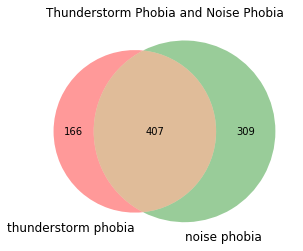

Chi-squared Test of Independence for thunderstorm phobia and noise phobia:
chi2 = 1331.774877, p = 1.41E-291, dof = 1
The resulting p-value is below the set significance threshold (0.01).


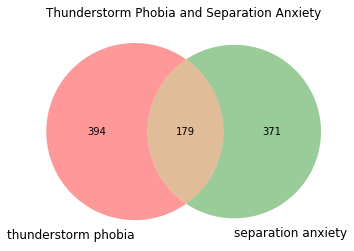

Chi-squared Test of Independence for thunderstorm phobia and separation anxiety:
chi2 = 183.558945, p = 8.10E-42, dof = 1
The resulting p-value is below the set significance threshold (0.01).


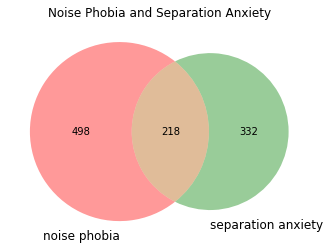

Chi-squared Test of Independence for noise phobia and separation anxiety:
chi2 = 218.299764, p = 2.12E-49, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [32]:
# Create the necessary dataframe.
fields = 'q04_1, q04_2, q04_9'
labels = ['thunderstorm phobia', 'noise phobia', 'separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

pairs = [['thunderstorm phobia', 'noise phobia'],
         ['thunderstorm phobia', 'separation anxiety'],
         ['noise phobia', 'separation anxiety']]

titles = ['Thunderstorm Phobia and Noise Phobia',
          'Thunderstorm Phobia and Separation Anxiety',
          'Noise Phobia and Separation Anxiety']

counter = 0
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Convert the cross tabulated dataframe to a series of sums.
    d = {pair[0]: contingency[0][1],
         pair[1]: contingency[1][0],
         'both': contingency[1][1]}   
    cross_sums = pd.Series(d)
    # Display the cross tabulated data as a venn diagram.
    labels = cross_sums.index.values
    venn2(cross_sums, set_labels=labels[0:2])
    plt.title(titles[counter])
    plt.show()
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    checkSignificance(p)
    counter += 1

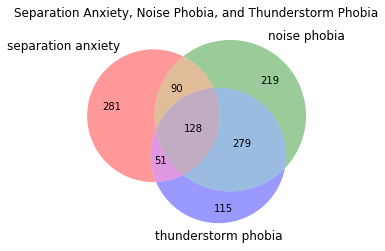

Chi-squared Test of Independence for separation anxiety and the combination of noise and
thunderstorm phobia:
chi2 = 285.272663, p = 1.53E-61, dof = 3
The resulting p-value is below the set significance threshold (0.01).


In [33]:
# Create a contingency table.
contingency = pd.crosstab(df['separation anxiety'], [df['noise phobia'],
                                                     df['thunderstorm phobia']])

# Convert the cross tabulated dataframe to a series of sums.
d = {'separation anxiety': contingency[0][0][1],
     'noise phobia': contingency[1][0][0],
     'separation-noise': contingency[1][0][1],
     'thunderstorm phobia': contingency[0][1][0],
     'separation-thunderstorm': contingency[0][1][1],
     'noise-thunderstorm': contingency[1][1][0],     
     'all': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = [cross_sums.index.values[i] for i in [0, 1, 3]]
venn3(cross_sums, set_labels=labels)
plt.title('Separation Anxiety, Noise Phobia, and Thunderstorm Phobia')
plt.show()

# Execute a chi-squared test of independence.
title = ('Chi-squared Test of Independence for separation anxiety and the combination of '
         'noise and thunderstorm phobia:')
print(textwrap.fill(title, width=90))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

## Compulsion and Fearful/Anxious Behaviors

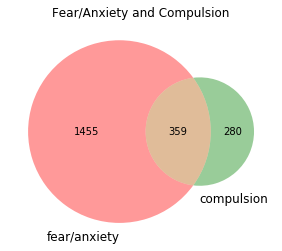

In [34]:
# Create the necessary hdataframe.
fields = 'q02_main_2, q02_main_3'
labels = ['fear/anxiety', 'compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df['fear/anxiety'], df['compulsion'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'fear/anxiety': contingency[0][1],
     'compulsion': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Fear/Anxiety and Compulsion')
plt.show()

In [35]:
# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1
The resulting p-value is below the set significance threshold (0.01).


## Aggression and Fearful/Anxious Behavior

### Overall Aggression and Fearful/Anxious Behavior

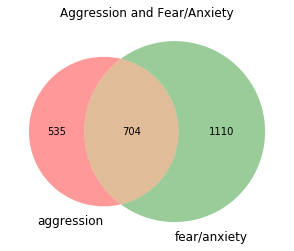

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [36]:
# Create the necessary dataframe.
fields = 'q02_main_1, q02_main_2'
labels = ['aggression', 'fear/anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fear/anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'aggression': contingency[0][1],
     'fear/anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Aggression and Fear/Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

### Specifically Owner Directed Aggression and Fearful/Anxious Behavior

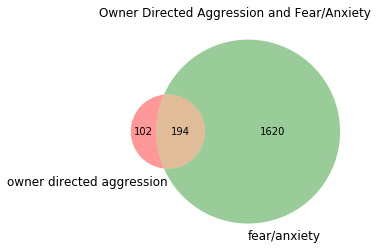

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [37]:
# Create the necessary dataframe.
fields = 'q03_main_1, q02_main_2'
labels = ['aggression', 'fear/anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fear/anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'owner directed aggression': contingency[0][1],
     'fear/anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Owner Directed Aggression and Fear/Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

### Specifically Owner Directed Aggression and Separation Anxiety

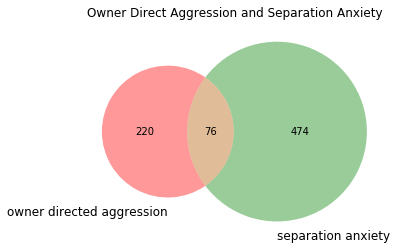

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [38]:
# Create the necessary dataframe.
fields = 'q03_main_1, q04_9'
labels = ['aggression', 'anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'owner directed aggression': contingency[0][1],
     'separation anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Owner Direct Aggression and Separation Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

## Chi-squared Matrix

### Reference Chart

In [39]:
# Construct lists.
locs = []
labels = []
categories = []
for cat, subdict in LABELS.items():
    for key, value in  subdict.items():
        locs.append(key)
        labels.append(value)
        categories.append(cat)

# Display lists in a chart for use as a reference.
data = [go.Table(columnwidth = [125, 225, 300],
                 header=dict(values=['Location', 'Category', 'Label'],
                             fill = dict(color='#B0C4DE'),
                             align = ['left'] * 3),
                 cells=dict(values=[locs, categories, labels],
                            align = ['left'] * 3))]
layout = go.Layout(width=650,
                   height=1600,
                   margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Linear Heatmap

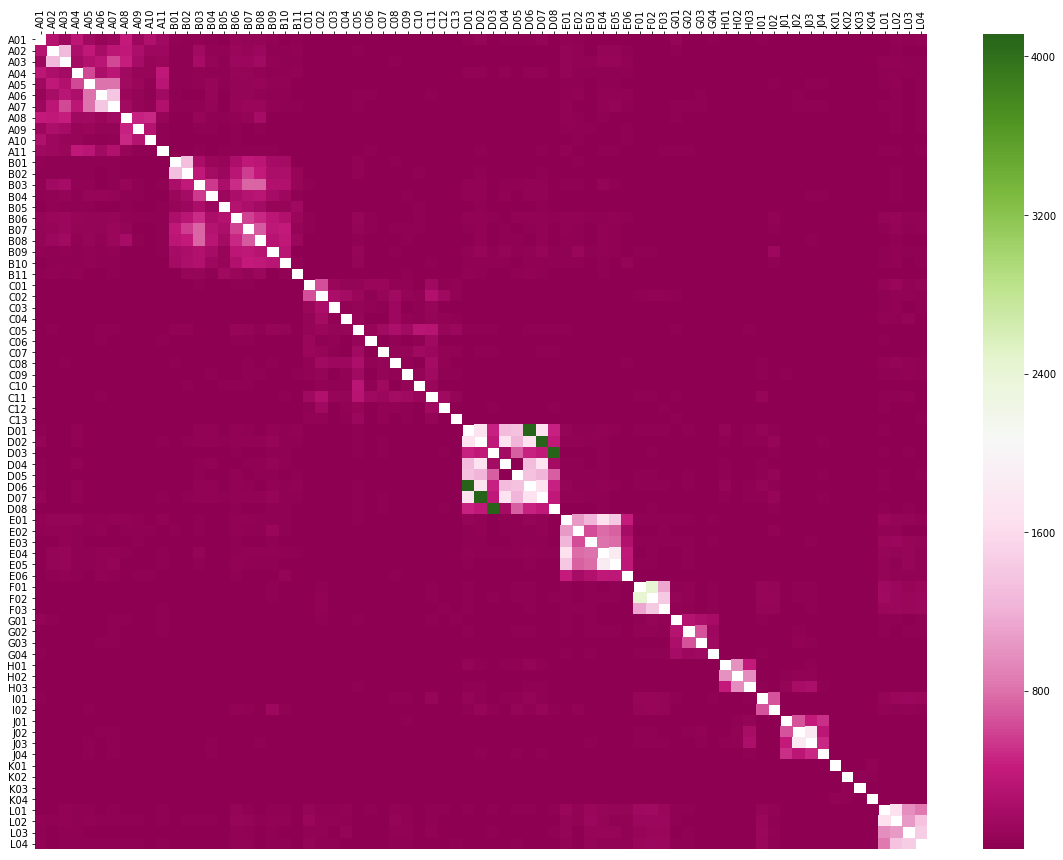

In [40]:
if CHI2_MATRIX.empty:
    CHI2_MATRIX = createChiSquaredMatrix()

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(ax=ax, data=CHI2_MATRIX, cmap="PiYG")
plt.yticks(rotation=0)
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

### Logarithmic Heatmap

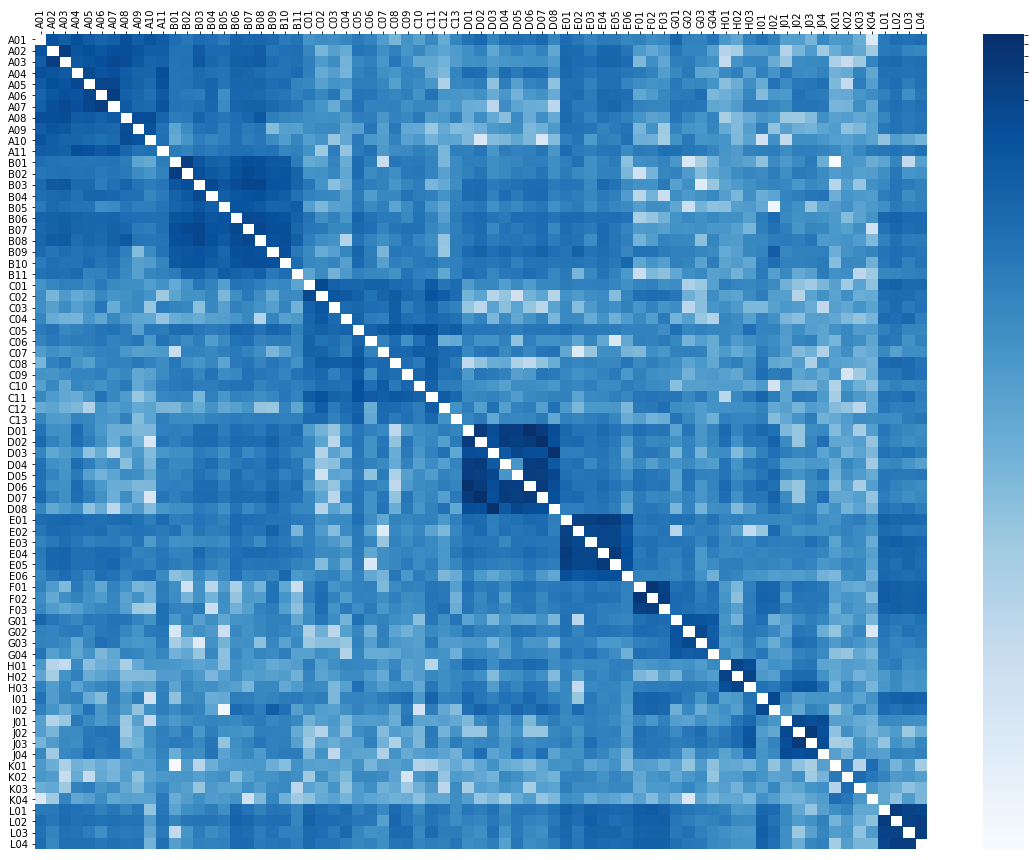

In [41]:
if CHI2_MATRIX.empty:
    CHI2_MATRIX = createChiSquaredMatrix()

# Heatmap
import warnings; warnings.simplefilter('ignore')
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(20, 15))
chi2_min = CHI2_MATRIX.min(skipna=True).min()
chi2_max = CHI2_MATRIX.max(skipna=True).max()
sns.heatmap(ax = ax, data=CHI2_MATRIX, norm=LogNorm(vmin=chi2_min, vmax=chi2_max),
            cmap="Blues")
plt.yticks(rotation=0)
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()